In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [275]:
class EnergyefficiencyDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
          #scale y
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2, 16),
      nn.Tanh(),
      nn.Linear(16, 32),
      nn.Tanh(),
      nn.Linear(32, 1)
    )

  def forward(self, x):
    return self.layers(x)

In [276]:
def initialize_weights(m):
  if isinstance(m, nn.Linear):
      n = m.in_features
      y = 1.0 / np.sqrt(n)
      # y = 10
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)

def my_plot(epochs, loss, val_loss_list,test_loss_list,epo, lr):
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss_list, label='val_loss')
    plt.plot(epochs, test_loss_list, label='test_loss')
    plt.legend()
    title = "epochs:"+str(epo)+"learning_rate:"+str(lr)
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("training error")
    plt.savefig('title.png')
    plt.show()

In [314]:
# Set fixed random number seed
torch.manual_seed(42)

path = '/content/func_app0.csv'
df = pd.read_csv(path)
X, y = np.array(df[['x1','x2']]), np.array(df['y'])

X1, X_test, y1, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.125, random_state=42)

all_dataset = EnergyefficiencyDataset(X, y, scale_data=False)
train_dataset = EnergyefficiencyDataset(X_train, y_train, scale_data=False)
val_dataset = EnergyefficiencyDataset(X_val, y_val, scale_data=False)
test_dataset = EnergyefficiencyDataset(X_test, y_test, scale_data=False)

allloader = torch.utils.data.DataLoader(all_dataset, batch_size=1, shuffle=True, num_workers=1)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)

In [315]:
X_train[0]

array([0.72575255, 4.4570042 ])

In [317]:
y_train[0]

1.3766800291494743

In [319]:
train_dataset[0]

(tensor([0.72575255, 4.45700420], dtype=torch.float64),
 tensor(1.37668003, dtype=torch.float64))

In [278]:
def train(dataloader, model, loss_fun, optimizer):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.train()
  train_loss = 0.0
  for i,data in enumerate(dataloader):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()

    outputs = model(inputs)
    loss = loss_fun(outputs, targets)
    train_loss += loss

    #backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%100==0:
      loss, curr = loss.item(), i*len(inputs)
      print(f"loss : {loss}   [{curr}/{size}]")
  train_loss /= num_batches
  return train_loss

In [279]:
def test(dataloader, model, loss_fun):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  with torch.no_grad():
    test_loss = 0.0
    for i,data in enumerate(dataloader):
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()

      pred = model(inputs)
      test_loss += loss_fun(pred, targets).item()

    test_loss /= num_batches
    print("test error : ")
    print(f"loss : {test_loss}")
  return test_loss

In [280]:
mlp = MLP()
mlp.apply(initialize_weights)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [281]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [282]:
train_loss_list= []
val_loss_list = []
test_loss_list = []
for epoch in range(0, 50):
  scheduler.step()
  print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
  print(f"epoch {epoch+1}\n-------------------")
  l1 = train(trainloader, mlp, loss_function, optimizer)
  l2 = test(valloader, mlp, loss_function)
  l3 = test(testloader, mlp, loss_function)
  train_loss_list.append(l1.detach())
  val_loss_list.append(l2)
  test_loss_list.append(l3)
print("done!")

Epoch-0 lr: 0.001
epoch 1
-------------------
loss : 0.4606122076511383   [0/350]
loss : 0.001561464974656701   [100/350]
loss : 0.5267921090126038   [200/350]
loss : 0.3047592043876648   [300/350]
test error : 
loss : 0.20104138654423878
test error : 
loss : 0.3342325898428589
Epoch-1 lr: 0.001
epoch 2
-------------------
loss : 0.000648509303573519   [0/350]
loss : 0.10282918065786362   [100/350]
loss : 0.011838281527161598   [200/350]
loss : 0.07522788643836975   [300/350]
test error : 
loss : 0.1936692163254884
test error : 
loss : 0.36426010071794734
Epoch-2 lr: 0.001
epoch 3
-------------------
loss : 0.4972458779811859   [0/350]
loss : 0.015044286847114563   [100/350]
loss : 0.02134818397462368   [200/350]
loss : 0.19760634005069733   [300/350]
test error : 
loss : 0.21038601955980993
test error : 
loss : 0.3011761610896383
Epoch-3 lr: 0.001
epoch 4
-------------------
loss : 0.3788360357284546   [0/350]
loss : 0.6917054057121277   [100/350]
loss : 0.20555530488491058   [200/350

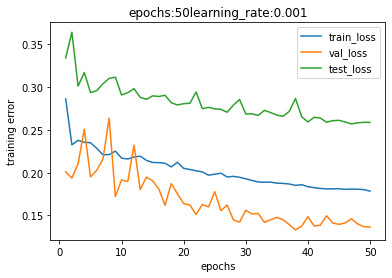

In [283]:
# plotting
num_epochs = len(train_loss_list)
my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_loss_list, val_loss_list, test_loss_list,num_epochs, 1e-3)

In [284]:
from torch.nn.modules.module import T
def plot_scatter(dataloader, model, loss_fun):
  true = []
  pred = []
  for i,data in enumerate(dataloader):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    outputs = model(inputs)
    true.append(targets.numpy()[0])
    pred.append(outputs.item())
  
  plt.hist(true)
  plt.title("distribution of desired output")
  plt.show()
  plt.hist(pred)
  plt.title("distribution of model output")
  plt.show()
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.scatter(pred,true)
  plt.plot([0, 2], [0, 2], color = 'black', linewidth = 2)
  plt.title("scatter plot")
  plt.ylabel("desired output")
  plt.xlabel("model output")
  ax.set_yticks(np.arange(0, 3, 1.0))
  ax.set_xticks(np.arange(0, 3, 1.0))
  plt.show()

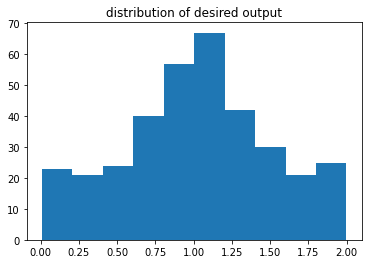

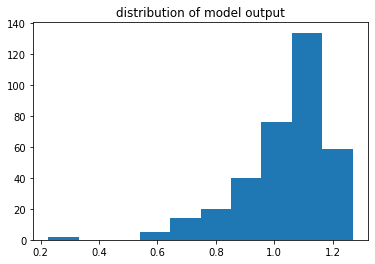

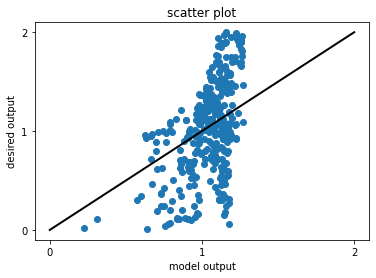

In [285]:
plot_scatter(trainloader,mlp,loss_function)

In [341]:
def plot_3d(x,y,z,z_label):
  ax = plt.axes(projection='3d')
  ax.plot_trisurf(x, y, z,cmap='viridis', edgecolor='none')
  ax.set_xlabel("x1 coordinate")
  ax.set_ylabel("x2 label")
  ax.set_zlabel(z_label)

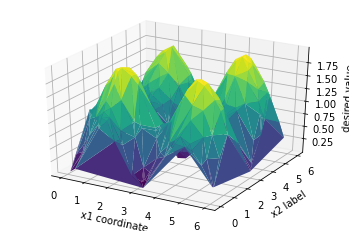

In [342]:
a = X_train[:,0]
b = X_train[:,1]
c = y_train
plot_3d(a,b,c,"desired value")

In [343]:
d = []
e = []
f = []
for i,data in enumerate(trainloader):
  inputs, targets = data
  inputs, targets = inputs.float(), targets.float()
  outputs = mlp(inputs)
  d.append(inputs.numpy()[0][0])
  e.append(inputs.numpy()[0][1])
  f.append(outputs.item())

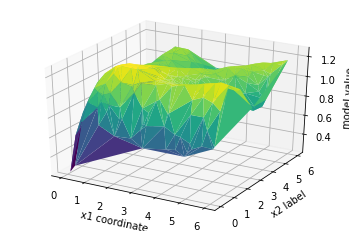

In [344]:
plot_3d(d,e,f,"model value")